In [1]:
DIR = "norms"

import ROOT

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from uncertainties import ufloat
from scipy.integrate import quad

# Temperature steps
temperatures = [0.007,0.008,0.009,0.010,0.011,0.012,0.013,0.014,0.015,
                0.016,0.018,0.020,0.025,0.030,0.040,0.050,0.060,0.070,
                0.080,0.090,0.100,0.110,0.120,0.130,0.140,0.150,0.160,
                0.180,0.200,0.250,0.300,0.350,0.400,0.450,0.500,0.600,
                0.700,0.800,0.900,1.000,1.250,1.500,1.750,2.000,2.500,
                3.000,3.500,4.000,5.000,6.000,7.000,8.000,9.000,10.00]

# Steps of integrations
nSteps = 100000

# Constants
M0 = 1.00727647             # Proton mass        (amu)
M1 = 12                     # Carbon-12 mass     (amu)
Mr = M0 * M1 / ( M0 + M1 )  # Reduced mass
Z0 = 1                      # Proton charge
Z1 = 6                      # Carbon charge
k  = 8.6171e-2              # Boltzmann constant (MeV GK^(-1))
Na = 6.02214179e23          # Avogadro number
c  = 29979245800            # Speed of light cm/s
uconv = 931.4940880         # Conversion factors

# Cross Section buffers
sfactor        = ROOT.TGraph( )
sfactor_min    = ROOT.TGraph( )
sfactor_max    = ROOT.TGraph( )

Welcome to JupyROOT 6.28/04


In [2]:
def calculate_sigma( E, sfactor ):
    return sfactor.Eval( E, 0, "S") * np.exp( -0.989534 * Z0 * Z1 * np.sqrt( Mr / E ) ) / E
    
def d_integral( E, T, sfactor ):
    if( E > 50 or E < 0.001 ): return 0
    else: sigma = calculate_sigma( E, sfactor )    
    return sigma * E * np.exp( -E / ( k * T ) )

def integrate( E_min, E_max, T, sfactor ):
    integral, _ = quad( d_integral, E_min, E_max, epsabs=0, epsrel=1e-6, limit=100000, args=(T, sfactor) )   
    return integral

In [3]:
data = np.loadtxt( "results/{}/data/Segment 1.txt".format(DIR) )
ndata = len( data )
for i in range( ndata ):
    sfactor.SetPoint( i, data[i][0], data[i][1] )
    sfactor_min.SetPoint( i, data[i][0], data[i][1] - data[i][2] )
    sfactor_max.SetPoint( i, data[i][0], data[i][1] + data[i][3] )
    if( i == ndata - 1 ):
        sfactor.SetPoint( i + 1, data[i][0] + 0.01, data[i][1] )
        sfactor_min.SetPoint( i + 1, data[i][0] + 0.01, data[i][1] - data[i][2] )
        sfactor_max.SetPoint( i + 1, data[i][0] + 0.01, data[i][1] + data[i][3] )
        sfactor.SetPoint( i + 2, data[i][0] + 0.1, data[i][1] )
        sfactor_min.SetPoint( i + 2, data[i][0] + 0.1, data[i][1] - data[i][2] )
        sfactor_max.SetPoint( i + 2, data[i][0] + 0.1, data[i][1] + data[i][3] )
        sfactor.SetPoint( i + 3, data[i][0] + 1, data[i][1] )
        sfactor_min.SetPoint( i + 3, data[i][0] + 1, data[i][1] - data[i][2] )
        sfactor_max.SetPoint( i + 3, data[i][0] + 1, data[i][1] + data[i][3] )
        sfactor.SetPoint( i + 4, 50, data[i][1] )
        sfactor_min.SetPoint( i + 4, 50, data[i][1] - data[i][2] )
        sfactor_max.SetPoint( i + 4, 50, data[i][1] + data[i][3] )

In [4]:
output = open( "results/rates/{}.rate".format(DIR), "w" )

for T in tqdm(temperatures):
    
    const = 1e-24 * Na * c * np.sqrt( 8 / ( np.pi * Mr * uconv ) )/pow( k * T, 3/2 )    

    mean = const * integrate( 0.001, 50, T, sfactor )
    sigma_min = const * integrate( 0.001, 50, T, sfactor_min )
    sigma_max = const * integrate( 0.001, 50, T, sfactor_max )
    
    output.write( "{:.3f} {:.3e} {:.3e} {:.3e}\n".format( T, sigma_min, mean, sigma_max ) ) 

output.close()

100%|██████████| 54/54 [00:05<00:00,  9.49it/s]


In [5]:
def normalize( rate, norms ):
    for i, row in enumerate( rate ):
        # Find closest temperature
        k = np.argmin( np.abs( row[0] - norms[:,0] ) )
        # Normalize
        rate[i,1] /= norms[k,2]
        rate[i,2] /= norms[k,2]
        rate[i,3] /= norms[k,2]
    return rate

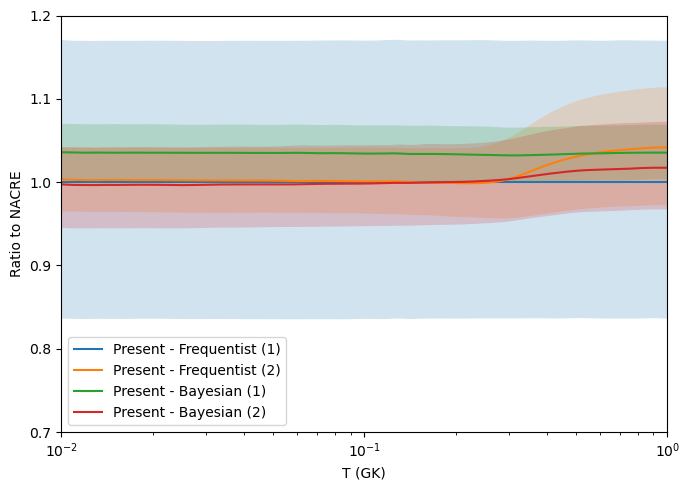

In [13]:
from scipy import interpolate

rates = { "NACRE": np.loadtxt( "rates/12c_pg_nacre.rate" ), 
          "Present - Frequentist (1)" : np.loadtxt( "results/rates/initial.rate" ),
          "Present - Frequentist (2)" : np.loadtxt( "results/rates/norms.rate" ),
          "Present - Bayesian (1)" : np.loadtxt( "results/rates/emcee.rate" ),
          "Present - Bayesian (2)" : np.loadtxt( "results/rates/ptemcee.rate" )
            }

rates["Present - Frequentist (1)"][:,1] *= 1.1
rates["Present - Frequentist (1)"][:,2] *= 1.1
rates["Present - Frequentist (1)"][:,3] *= 1.1

norms = rates["Present - Frequentist (1)"].copy( )
for key in rates:
    rates[key] = normalize( rates[key], norms )

fig, ax = plt.subplots( figsize=(7,5) )

for key in rates.keys( ):
    if( key == "NACRE" ): continue
    x, y, y_min, y_max = rates[key][:,0], rates[key][:,2], rates[key][:,1], rates[key][:,3]
    x_new = np.linspace(0.01, 10, 10000)
    y_new = interpolate.make_interp_spline(x, y)(x_new)
    y_min_new = interpolate.make_interp_spline(x, y_min)(x_new)
    y_max_new = interpolate.make_interp_spline(x, y_max)(x_new)
    ax.fill_between( x_new, y_min_new, y_max_new, alpha=0.2 )
    #ax.plot( x_new, y_min_new, linestyle="--" )
    #ax.plot( x_new, y_max_new, linestyle="--" )
    ax.plot( x_new, y_new, label=key )

ax.set_xscale( "log" )

ax.set_xlim( 0.01, 1)
ax.set_ylim( 0.7, 1.2)

ax.set_xlabel( "T (GK)" )
#ax.set_ylabel( r"$\langle \sigma v \rangle$ (cm$^3$ s$^{-1}$)" )
ax.set_ylabel( r"Ratio to NACRE" )
ax.legend( loc="lower left" )

plt.tight_layout()

plt.savefig( "results/rates/figures/rate_nacre.pdf" )
plt.show()

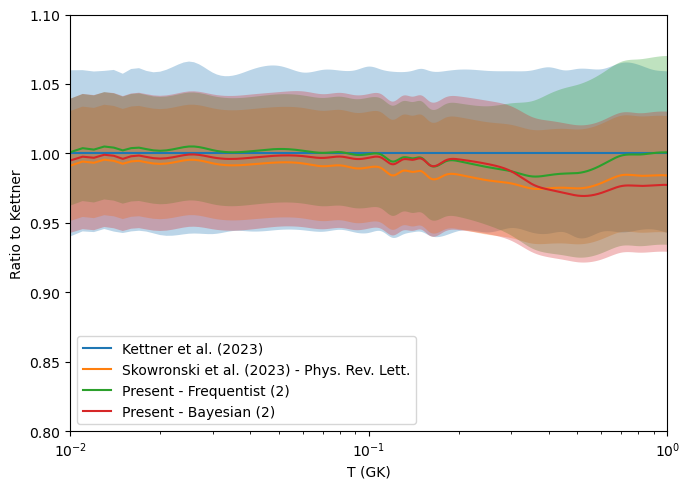

In [7]:
from scipy import interpolate

rates = { "Kettner et al. (2023)": np.loadtxt( "rates/12c_pg_kettner.rate" ),
          "Skowronski et al. (2023) - Phys. Rev. Lett.": np.loadtxt( "rates/12c_pg_prl.rate" ), 
          "Present - Frequentist (2)" : np.loadtxt( "results/rates/norms.rate" ),
          "Present - Bayesian (2)" : np.loadtxt( "results/rates/ptemcee.rate" )
            }

norms = rates["Kettner et al. (2023)"].copy( )
for key in rates:
    rates[key] = normalize( rates[key], norms )

fig, ax = plt.subplots( figsize=(7,5) )

for key in rates.keys( ):
    x, y, y_min, y_max = rates[key][:,0], rates[key][:,2], rates[key][:,1], rates[key][:,3]
    x_new = np.linspace(0.01, 10, 10000)
    y_new = interpolate.make_interp_spline(x, y)(x_new)
    y_min_new = interpolate.make_interp_spline(x, y_min)(x_new)
    y_max_new = interpolate.make_interp_spline(x, y_max)(x_new)
    ax.fill_between( x_new, y_min_new, y_max_new, alpha=0.3 )
    ax.plot( x_new, y_new, label=key )

ax.set_xscale( "log" )

ax.set_xlim( 0.01, 1)
ax.set_ylim( 0.8, 1.1)

ax.set_xlabel( "T (GK)" )
#ax.set_ylabel( r"$\langle \sigma v \rangle$ (cm$^3$ s$^{-1}$)" )
ax.set_ylabel( r"Ratio to Kettner" )
ax.legend( loc="lower left" )

plt.tight_layout()

plt.savefig( "results/rates/figures/rate_latest.pdf" )
plt.show()